In [16]:
# !pip install tensorflow matplotlib

     |████████████████████████████████| 11.6 MB 5.3 MB/s eta 0:00:01
     |████████████████████████████████| 88 kB 693 kB/s eta 0:00:011
     |████████████████████████████████| 2.2 MB 6.1 MB/s eta 0:00:01


In [1]:
import tflite_runtime.interpreter as tflite
import platform

import numpy as np
import matplotlib.pyplot as plt

EDGETPU_SHARED_LIB = {
  'Linux': 'libedgetpu.so.1',
  'Darwin': 'libedgetpu.1.dylib',
  'Windows': 'edgetpu.dll'
}[platform.system()]

ModuleNotFoundError: No module named 'matplotlib'

In [3]:
def make_interpreter(model_file):
  model_file, *device = model_file.split('@')
  return tflite.Interpreter(
      model_path=model_file,
      experimental_delegates=[
          tflite.load_delegate(EDGETPU_SHARED_LIB,
                               {'device': device[0]} if device else {})
      ])

In [7]:
from tensorflow import keras
fashion_mnist = keras.datasets.fashion_mnist

(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

4423680/4422102 [==============================] - 1s 0us/step


In [8]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

In [9]:
train_images = train_images / 255.0

test_images = test_images / 255.0

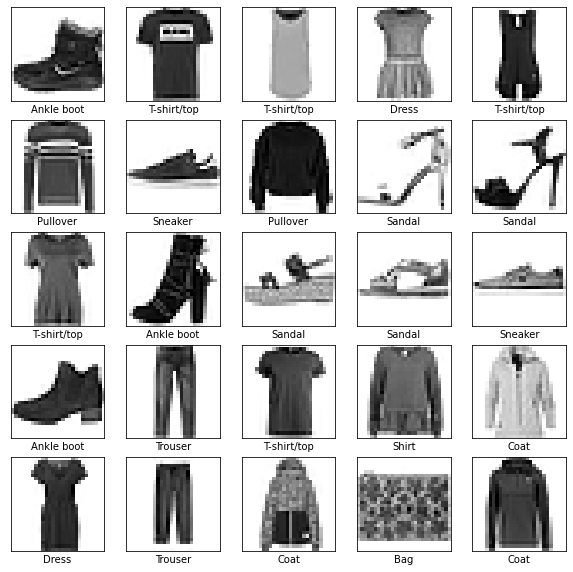

In [19]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i], cmap=plt.cm.binary)
    plt.xlabel(class_names[train_labels[i]])
plt.show()

In [56]:
interpreter = make_interpreter("./my_model/mnist_keras_model.tflite")
interpreter.allocate_tensors()
interpreter.get_output_details()[0]['shape']

array([ 1, 10], dtype=int32)

In [57]:
# Get input and output tensors.
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

print(input_details)
print(output_details)

[{'name': 'flatten_input', 'index': 0, 'shape': array([ 1, 28, 28], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}}]
[{'name': 'Identity', 'index': 9, 'shape': array([ 1, 10], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}}]


In [58]:
np.array([test_images[0]]).shape

(1, 28, 28)

In [60]:
np.array([next(iter(test_images))]).shape

(1, 28, 28)

In [104]:
def predict_single(test_image):    
    input_shape = input_details[0]['shape']
    input_data = np.array(np.array([test_image]), dtype=np.float32)
    interpreter.set_tensor(input_details[0]['index'], input_data)
    interpreter.invoke()
    output_data = interpreter.get_tensor(output_details[0]['index'])
    return output_data[0]

In [109]:
predictions = []
for index, img in enumerate(test_images):
    predictions.append(predict_single(img))   
    

In [111]:
lnpredictions

10000

In [100]:
def plot_image(i, predictions_array, true_label, img):
  predictions_array, true_label, img = predictions_array[i], true_label[i], img[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])

  plt.imshow(img, cmap=plt.cm.binary)

  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'

  plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                100*np.max(predictions_array),
                                class_names[true_label]),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
  predictions_array, true_label = predictions_array[i], true_label[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  thisplot = plt.bar(range(10), predictions_array, color="#777777")
  plt.ylim([0, 1])
  predicted_label = np.argmax(predictions_array)

  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('blue')

In [112]:
i = 0
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, predictions, test_labels, test_images)
plt.subplot(1,2,2)
plot_value_array(i, predictions,  test_labels)
plt.show()

In [113]:
i = 12
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, predictions, test_labels, test_images)
plt.subplot(1,2,2)
plot_value_array(i, predictions,  test_labels)
plt.show()

In [114]:
# 처음 X 개의 테스트 이미지와 예측 레이블, 진짜 레이블을 출력합니다
# 올바른 예측은 파랑색으로 잘못된 예측은 빨강색으로 나타냅니다
num_rows = 5
num_cols = 3
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_image(i, predictions, test_labels, test_images)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_value_array(i, predictions, test_labels)
plt.show()